In [0]:
%pip install pmdarima
%pip install arch
%pip install keras
%pip install optree
%pip install tensorflow
%pip install keras-tuner

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-18e9425a-1c02-4ccf-992e-71063be81663
    Can't uninstall 'numpy'. No files were found to uninstall.
Note: you may need to restart the kernel using 

In [0]:
dbutils.library.restartPython()

In [0]:
import pyspark

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, TimestampType
from pyspark.sql.functions import explode, posexplode

import pmdarima as pm
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
df_bel_stream_15m_complete = spark.table("default.df_bel_stream_15m_complete")

df_bel_stream_15m_sub = df_bel_stream_15m_complete.filter((df_bel_stream_15m_complete['street']== '1593'))

#df_bel_stream_15m_sub = df_bel_stream_15m_complete.filter((df_bel_stream_15m_complete['street']== '1593') & (df_bel_stream_15m_complete['datetime_full'] >= '2019-01-25 00:00:00.000+00:00'))


#df_bel_stream_15m_sub = df_bel_stream_15m_complete.filter((df_bel_stream_15m_complete['street']== '1593') | (df_bel_stream_15m_complete['street']== '2613') | (df_bel_stream_15m_complete['street']== '1845'))

In [0]:
df_bel_stream_15m_sub = df_bel_stream_15m_sub.withColumn("datetime", col("datetime_full"))

df_bel_stream_15m_sub = df_bel_stream_15m_sub.orderBy("datetime_full")

pdf = df_bel_stream_15m_sub.toPandas()

# Asegúrate de que la columna de fecha esté en el formato de fecha correcto
pdf['datetime_full'] = pd.to_datetime(pdf['datetime_full'])

# Establece la columna de fecha como índice
pdf.set_index('datetime_full', inplace=True)


### ARIMA con training-testing ok

In [0]:

# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]
    
    # Ajustar el modelo auto_arima
    model = pm.auto_arima(train_data, seasonal=False, stepwise=True)
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    pred = model.predict(n_periods=prediction_interval)
    
    # Agregar predicciones a la lista
    predictions.extend(pred)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")


                    street        date  month  ...  count      speed  predictions
datetime_full                                  ...                               
2019-02-01 00:00:00   1593  2019-02-01      2  ...     38  86.986839          NaN
2019-02-01 00:15:00   1593  2019-02-01      2  ...     63  85.883598          NaN
2019-02-01 00:30:00   1593  2019-02-01      2  ...     69  86.867149          NaN
2019-02-01 00:45:00   1593  2019-02-01      2  ...     50  85.876663          NaN
2019-02-01 01:00:00   1593  2019-02-01      2  ...     46  87.134056          NaN
...                    ...         ...    ...  ...    ...        ...          ...
2019-02-28 22:45:00   1593  2019-02-28      2  ...     53  86.022011    59.747752
2019-02-28 23:00:00   1593  2019-02-28      2  ...     46  86.731888    51.481464
2019-02-28 23:15:00   1593  2019-02-28      2  ...     39  86.692307    51.481464
2019-02-28 23:30:00   1593  2019-02-28      2  ...     54  86.913582    51.481464
2019-02-28 23:45

In [0]:
display(result_df)

street date month week_of_year day_of_month day_of_week weekend time hour minutes time_period count speed predictions 1593 2019-02-01 2 5 1 6 0 00:00:00 0 0 night 38 86.98684 null 1593 2019-02-01 2 5 1 6 0 00:15:00 0 15 night 63 85.8836 null 1593 2019-02-01 2 5 1 6 0 00:30:00 0 30 night 69 86.86715 null 1593 2019-02-01 2 5 1 6 0 00:45:00 0 45 night 50 85.87666 null 1593 2019-02-01 2 5 1 6 0 01:00:00 1 0 night 46 87.134056 null 1593 2019-02-01 2 5 1 6 0 01:15:00 1 15 night 55 82.6303 null 1593 2019-02-01 2 5 1 6 0 01:30:00 1 30 night 63 81.478836 null 1593 2019-02-01 2 5 1 6 0 01:45:00 1 45 night 58 84.083336 null 1593 2019-02-01 2 5 1 6 0 02:00:00 2 0 night 48 83.73055 null 1593 2019-02-01 2 5 1 6 0 02:15:00 2 15 night 86 84.800385 null 1593 2019-02-01 2 5 1 6 0 02:30:00 2 30 night 69 85.30193 null 1593 2019-02-01 2 5 1 6 0 02:45:00 2 45 night 51 84.745094 null 1593 2019-02-01 2 5 1 6 0 03:00:00 3 0 night 80 83.11875 null 1593 2019-02-01 2 5 1 6 0 03:15:00 3 15 night 110 81.57576 null 1593 2019-02-01 2 5 1 6 0 03:30:00 3 30 night 185 81.87027 null 1593 2019-02-01 2 5 1 6 0 03:45:00 3 45 night 147 82.774376 null 1593 2019-02-01 2 5 1 6 0 04:00:00 4 0 night 186 85.49462 null 1593 2019-02-01 2 5 1 6 0 04:15:00 4 15 night 251 84.63546 null 1593 2019-02-01 2 5 1 6 0 04:30:00 4 30 night 273 85.07509 null 1593 2019-02-01 2 5 1 6 0 04:45:00 4 45 night 250 85.664 null 1593 2019-02-01 2 5 1 6 0 05:00:00 5 0 night 292 84.10388 null 1593 2019-02-01 2 5 1 6 0 05:15:00 5 15 night 325 83.57333 null 1593 2019-02-01 2 5 1 6 0 05:30:00 5 30 night 293 83.01365 null 1593 2019-02-01 2 5 1 6 0 05:45:00 5 45 night 292 81.9589 null 1593 2019-02-01 2 5 1 6 0 06:00:00 6 0 morning 266 81.36591 null 1593 2019-02-01 2 5 1 6 0 06:15:00 6 15 morning 234 79.23006 null 1593 2019-02-01 2 5 1 6 0 06:30:00 6 30 morning 220 78.69242 null 1593 2019-02-01 2 5 1 6 0 06:45:00 6 45 morning 249 79.015396 null 1593 2019-02-01 2 5 1 6 0 07:00:00 7 0 morning 237 79.78622 null 1593 2019-02-01 2 5 1 6 0 07:15:00 7 15 morning 225 80.345924 null 1593 2019-02-01 2 5 1 6 0 07:30:00 7 30 morning 254 81.05249 null 1593 2019-02-01 2 5 1 6 0 07:45:00 7 45 morning 216 82.90278 null 1593 2019-02-01 2 5 1 6 0 08:00:00 8 0 morning 288 82.07176 null 1593 2019-02-01 2 5 1 6 0 08:15:00 8 15 morning 290 82.36379 null 1593 2019-02-01 2 5 1 6 0 08:30:00 8 30 morning 299 82.26868 null 1593 2019-02-01 2 5 1 6 0 08:45:00 8 45 morning 370 80.320724 null 1593 2019-02-01 2 5 1 6 0 09:00:00 9 0 morning 342 81.72855 null 1593 2019-02-01 2 5 1 6 0 09:15:00 9 15 morning 354 80.085686 null 1593 2019-02-01 2 5 1 6 0 09:30:00 9 30 morning 356 75.862595 null 1593 2019-02-01 2 5 1 6 0 09:45:00 9 45 morning 380 74.001755 null 1593 2019-02-01 2 5 1 6 0 10:00:00 10 0 morning 387 71.24419 null 1593 2019-02-01 2 5 1 6 0 10:15:00 10 15 morning 379 71.69657 null 1593 2019-02-01 2 5 1 6 0 10:30:00 10 30 morning 400 75.64687 null 1593 2019-02-01 2 5 1 6 0 10:45:00 10 45 morning 379 80.763855 null 1593 2019-02-01 2 5 1 6 0 11:00:00 11 0 morning 383 80.45779 null 1593 2019-02-01 2 5 1 6 0 11:15:00 11 15 morning 324 80.96965 null 1593 2019-02-01 2 5 1 6 0 11:30:00 11 30 morning 368 79.821106 null 1593 2019-02-01 2 5 1 6 0 11:45:00 11 45 morning 363 79.352844 null 1593 2019-02-01 2 5 1 6 0 12:00:00 12 0 afternoon 322 80.88768 null 1593 2019-02-01 2 5 1 6 0 12:15:00 12 15 afternoon 315 79.814285 null 1593 2019-02-01 2 5 1 6 0 12:30:00 12 30 afternoon 337 82.04945 null 1593 2019-02-01 2 5 1 6 0 12:45:00 12 45 afternoon 329 81.598274 null 1593 2019-02-01 2 5 1 6 0 13:00:00 13 0 afternoon 316 68.415085 null 1593 2019-02-01 2 5 1 6 0 13:15:00 13 15 afternoon 335 72.254974 null 1593 2019-02-01 2 5 1 6 0 13:30:00 13 30 afternoon 311 74.30091 null 1593 2019-02-01 2 5 1 6 0 13:45:00 13 45 afternoon 288 57.011806 null 1593 2019-02-01 2 5 1 6 0 14:00:00 14 0 afternoon 287 55.124157 null 1593 2019-02-01 2 5 1 6 0 14:15:00 14 15 afternoon 250 52.414932 null 1593 2019-02-01 2 5 1 6 0 14:30:00 14 30 afternoon 247 57.0361 null 1593 20

Databricks visualization. Run in Databricks to view.

In [0]:
# Resumen del modelo
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3107.801
Date:                Sun, 21 Jul 2024   AIC                           6225.601
Time:                        11:03:43   BIC                           6248.145
Sample:                    01-11-2019   HQIC                          6234.333
                         - 01-18-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4831      0.064     23.256      0.000       1.358       1.608
ar.L2         -0.7454      0.060    -12.340      0.000      -0.864      -0.627
ma.L1         -1.4937      0.058    -25.822      0.0

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Extraer valores reales y predicciones
y_true = result_df.dropna(subset=['predictions'])['count']
y_pred = result_df.dropna(subset=['predictions'])['predictions']

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    #msle = mean_squared_log_error(y_true, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    #print(f"Mean Squared Log Error (MSLE): {msle}")

# Llamar a la función para evaluar
evaluate_model(y_true, y_pred)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2167472976682096>, line 4
      1 from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
      3 # Extraer valores reales y predicciones
----> 4 y_true = result_df.dropna(subset=['predictions'])['count']
      5 y_pred = result_df.dropna(subset=['predictions'])['predictions']
      7 def evaluate_model(y_true, y_pred):

NameError: name 'result_df' is not defined

### ARIMA con exogenous

In [0]:
from pmdarima.arima.utils import nsdiffs

# estimate number of seasonal differences using a Canova-Hansen test
ch = nsdiffs(pdf['count'],
            m=672,  # commonly requires knowledge of dataset
            max_D=5000,
            test='ch')  # -> 0

# or use the OCSB test (by default)
ocsb = nsdiffs(pdf['count'],
        m=672,
        max_D=5000,
        test='ocsb')  # -> 0

In [0]:
ch

3

In [0]:
ocsb

0

In [0]:
# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]
    
    # Ajustar el modelo auto_arima
    model = pm.auto_arima(train_data, seasonal=True, stepwise=True) #exogenous , m= 3
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    pred = model.predict(n_periods=prediction_interval)
    
    # Agregar predicciones a la lista
    predictions.extend(pred)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")


In [0]:
# Resumen del modelo
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3138.783
Date:                Fri, 26 Jul 2024   AIC                           6281.566
Time:                        20:41:59   BIC                           6290.584
Sample:                    02-21-2019   HQIC                          6285.059
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1399      0.027      5.108      0.000       0.086       0.194
sigma2       676.9660     17.306     39.118      0.000     643.047     710.885
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Extraer valores reales y predicciones
y_true = result_df.dropna(subset=['predictions'])['count']
y_pred = result_df.dropna(subset=['predictions'])['predictions']

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    #msle = mean_squared_log_error(y_true, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    #print(f"Mean Squared Log Error (MSLE): {msle}")

# Llamar a la función para evaluar
evaluate_model(y_true, y_pred)

Mean Squared Error (MSE): 1772.106051124825
Mean Absolute Error (MAE): 26.93281963100501
R-squared (R2): 0.8904390522762162


In [0]:
# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]
    
    # Ajustar el modelo auto_arima
    model = pm.auto_arima(train_data, seasonal=True, stepwise=True, m= 3) #exogenous , m= 3
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    pred = model.predict(n_periods=prediction_interval)
    
    # Agregar predicciones a la lista
    predictions.extend(pred)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")

In [0]:
# Resumen del modelo
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3075.212
Date:                Fri, 26 Jul 2024   AIC                           6160.424
Time:                        20:47:43   BIC                           6182.967
Sample:                    01-25-2019   HQIC                          6169.155
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1182      0.062     17.917      0.000       0.996       1.240
ar.L2         -0.6944      0.063    -11.002      0.000      -0.818      -0.571
ma.L1         -1.2151      0.048    -25.308      0.0

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Extraer valores reales y predicciones
y_true = result_df.dropna(subset=['predictions'])['count']
y_pred = result_df.dropna(subset=['predictions'])['predictions']

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    #msle = mean_squared_log_error(y_true, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    #print(f"Mean Squared Log Error (MSLE): {msle}")

# Llamar a la función para evaluar
evaluate_model(y_true, y_pred)

Mean Squared Error (MSE): 1772.106051124825
Mean Absolute Error (MAE): 26.93281963100501
R-squared (R2): 0.8904390522762162


### ARIMA con transformacion box cox (no termina de correr)

In [0]:

import numpy as np
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]

    # Verificar que los datos sean estrictamente positivos
    if (train_data <= 0).any():
        offset = 1e-6
        train_data_adjusted = train_data + offset
    else:
        train_data_adjusted = train_data

    # Transformar la serie de tiempo
    train_data_transformed, lambda_value = boxcox(train_data_adjusted)
    
    # Ajustar el modelo auto_arima
    model = pm.auto_arima(train_data_transformed, seasonal=False, stepwise=True)
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    pred = model.predict(n_periods=prediction_interval)

    # Invertir la transformación Box-Cox
    if lambda_value == 0:
        pred_inv = np.exp(pred)
    else:
        pred_inv = (pred * lambda_value + 1) ** (1 / lambda_value) - 1
    
    # Agregar predicciones a la lista
    predictions.extend(pred_inv)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")


In [0]:
# Evaluar los residuos
residuals = model.resid()
plt.plot(residuals)
plt.show()

# Verificar la normalidad y homocedasticidad de los residuos
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='s')
plt.show()

### MODELO GARCH

### Optener p y q de GARCH

In [0]:
offset = 0.1
pdf['count'] = pdf['count']+ offset

# Supongamos que pdf contiene nuestra serie de tiempo
pdf['count'] = pdf['count'].replace(0, np.nan)  # Reemplaza ceros por NaN

# Calcular retornos logarítmicos (si no están ya en este formato)
returns = np.log(pdf['count']).diff().dropna()

# Escalar los retornos
scaling_factor = 10
scaled_returns = returns * scaling_factor

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF de retornos al cuadrado para seleccionar p y q

# Generar el correlograma
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(scaled_returns**2, lags=20, ax=ax)

ax.set_title('Función de Autocorrelación (ACF) de Retornos cuadrados', fontsize=16)
ax.set_xlabel('Lags', fontsize=10)
ax.set_ylabel('Autocorrelación', fontsize=10)

Text(0, 0.5, 'Autocorrelación')

/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Autocorrelación Parcial')

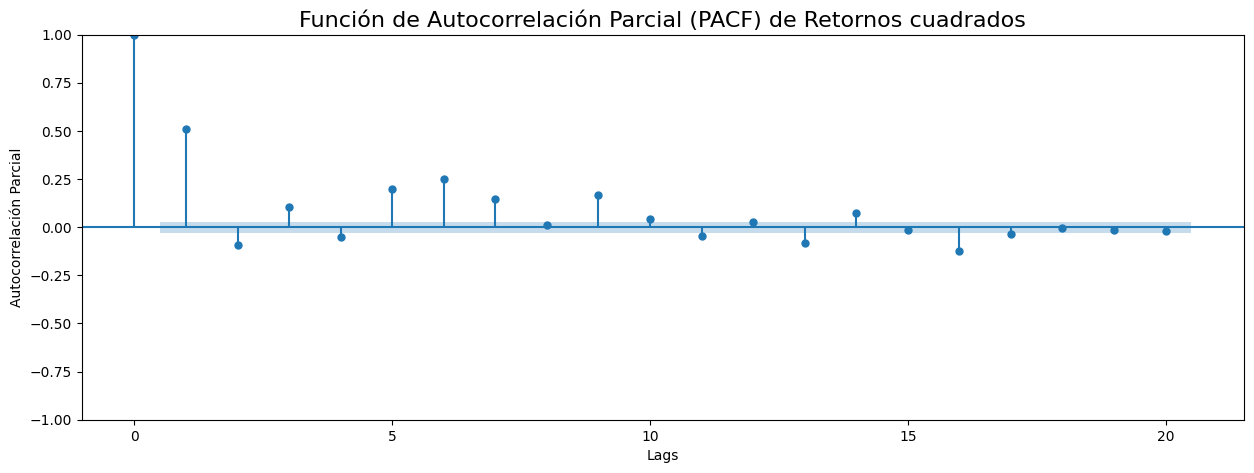

In [0]:
# Generar el correlograma
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(scaled_returns**2, lags=20, ax=ax)

ax.set_title('Función de Autocorrelación Parcial (PACF) de Retornos cuadrados', fontsize=16)
ax.set_xlabel('Lags', fontsize=10)
ax.set_ylabel('Autocorrelación Parcial', fontsize=10)

In [0]:
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(returns**2, nlags=30)
pacf_values = pacf(returns**2, nlags=30)
acf_values


array([1.        , 0.51213964, 0.19356929, 0.13639106, 0.0639546 ,
       0.15828172, 0.34655408, 0.38812017, 0.27884998, 0.27341973,
       0.22458381, 0.11286392, 0.14474127, 0.13505683, 0.17183633,
       0.21300178, 0.13075115, 0.07251382, 0.07358493, 0.07568762,
       0.07492786, 0.16558073, 0.151034  , 0.05620334, 0.04812752,
       0.01440662, 0.01593204, 0.03805761, 0.0571296 , 0.04236568,
       0.02436759])

In [0]:
pacf_values

array([ 1.        ,  0.51224033, -0.09319933,  0.10362963, -0.05188755,
        0.19979255,  0.25056177,  0.14724441,  0.00922846,  0.16841379,
        0.04494072, -0.04328971,  0.02784356, -0.08274946,  0.07370413,
       -0.01208469, -0.12334727, -0.03354655, -0.00202434, -0.01610816,
       -0.01890812,  0.09397113, -0.00166284, -0.01218178, -0.00532045,
       -0.02243306,  0.04026276, -0.05288293, -0.01201986, -0.02516418,
       -0.01386686])

In [0]:
import numpy as np
from arch import arch_model

def select_best_garch_model(returns, max_p=5, max_q=5):
    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_model = None
    
    aic_values = []
    bic_values = []
    orders = []

    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try:               
                model = arch_model(returns, vol='Garch', mean='ARX', p=p, q=q)
                model_fit = model.fit(disp="off")
                aic = model_fit.aic
                bic = model_fit.bic
                aic_values.append(aic)
                bic_values.append(bic)
                orders.append((p, q))
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
                    best_model = model_fit
                if bic < best_bic:
                    best_bic = bic
            except Exception as e:
                continue
    
    return best_order, best_model, best_aic, best_bic, orders, aic_values, bic_values

# Suponiendo que tienes una serie temporal de retornos escalados 'scaled_returns'
# Seleccionar el mejor modelo GARCH
best_order, best_model, best_aic, best_bic, orders, aic_values, bic_values = select_best_garch_model(scaled_returns)

print(f"Mejores parámetros (p, q): {best_order}")
print(f"Mejor AIC: {best_aic}")
print(f"Mejor BIC: {best_bic}")
print(best_model.summary())

# Imprimir los valores de AIC y BIC para cada combinación de p y q
for order, aic, bic in zip(orders, aic_values, bic_values):
    print(f"Orden (p, q): {order}, AIC: {aic}, BIC: {bic}")


Mejores parámetros (p, q): (1, 3)
Mejor AIC: 21782.571196636854
Mejor BIC: 21817.119922264235
                           AR - GARCH Model Results                           
Dep. Variable:                  count   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10885.3
Distribution:                  Normal   AIC:                           21782.6
Method:            Maximum Likelihood   BIC:                           21821.8
                                        No. Observations:                 5087
Date:                Sun, Jul 28 2024   Df Residuals:                     5086
Time:                        10:11:22   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
-------------------------------------------

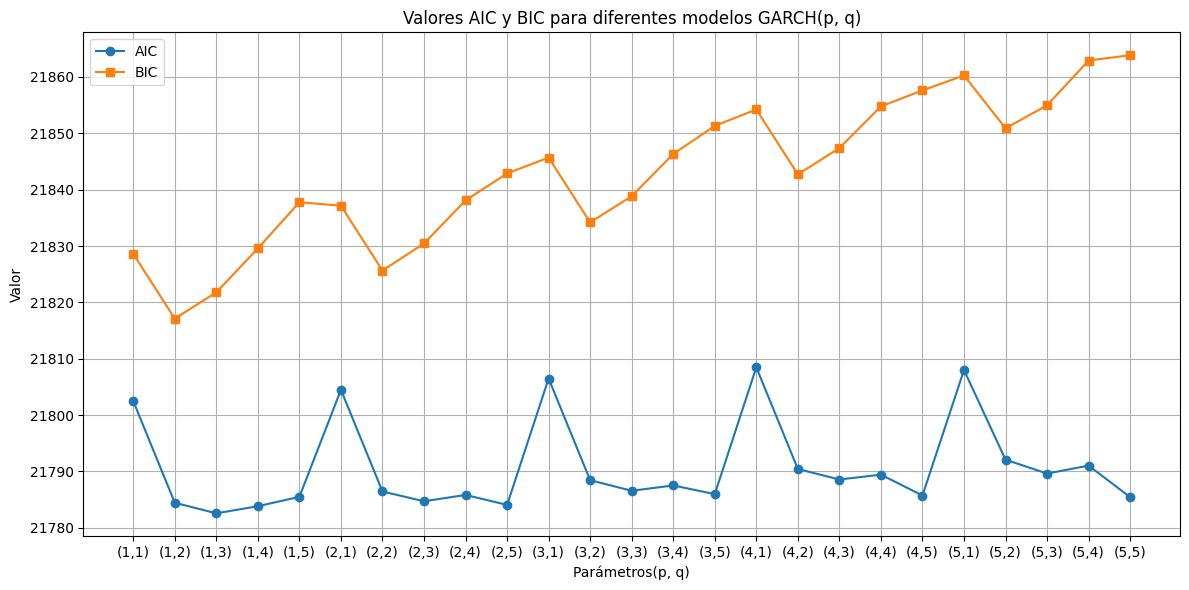

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Graficar los valores de AIC y BIC
fig, ax = plt.subplots(figsize=(12, 6))

order_labels = [f"({p},{q})" for (p, q) in orders]

ax.plot(order_labels, aic_values, marker='o', label='AIC')
ax.plot(order_labels, bic_values, marker='s', label='BIC')

ax.set_xlabel('Parámetros(p, q)')
ax.set_ylabel('Valor')
ax.set_title('Valores AIC y BIC para diferentes modelos GARCH(p, q)')
ax.legend()
ax.grid(True)

# Rotar las etiquetas del eje x para que se vean mejor
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [0]:
def select_best_garch_model(returns, max_p=5, max_q=5):
    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_model = None

    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try:               
                model = arch_model(returns, vol='GARCH', mean='ARX', p=p, q=q)
                model_fit = model.fit(disp="off")
                aic = model_fit.aic
                bic = model_fit.bic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
                    best_model = model_fit
                if bic < best_bic:
                    best_bic = bic
            except Exception as e:
                continue
    
    return best_order, best_model, best_aic, best_bic

# Seleccionar el mejor modelo GARCH
best_order, best_model, best_aic, best_bic = select_best_garch_model(scaled_returns)

print(f"Mejores parámetros (p, q): {best_order}")
print(f"Mejor AIC: {best_aic}")
print(f"Mejor BIC: {best_bic}")
print(best_model.summary())

Mejores parámetros (p, q): (1, 2)
Mejor AIC: 11507.643103376959
Mejor BIC: 11537.116557629086
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  count   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5748.82
Distribution:                  Normal   AIC:                           11507.6
Method:            Maximum Likelihood   BIC:                           11537.1
                                        No. Observations:                 2683
Date:                Sun, Jul 21 2024   Df Residuals:                     2682
Time:                        16:58:37   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------

In [0]:
# Evaluar residuos del mejor modelo
standardized_residuals = best_model.resid / best_model.conditional_volatility

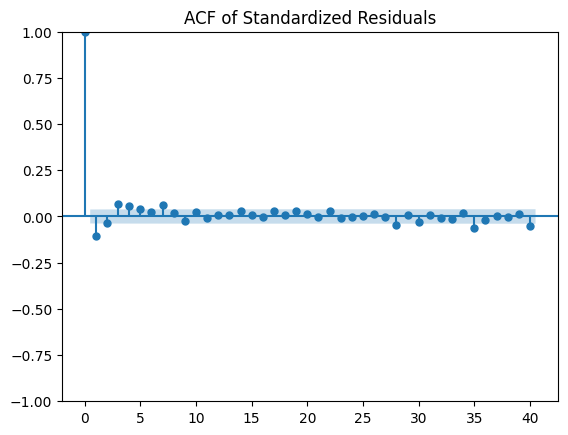

In [0]:
# Graficar ACF y PACF de residuos estandarizados
plot_acf(standardized_residuals, lags=40)
plt.title('ACF of Standardized Residuals')
plt.show()

/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


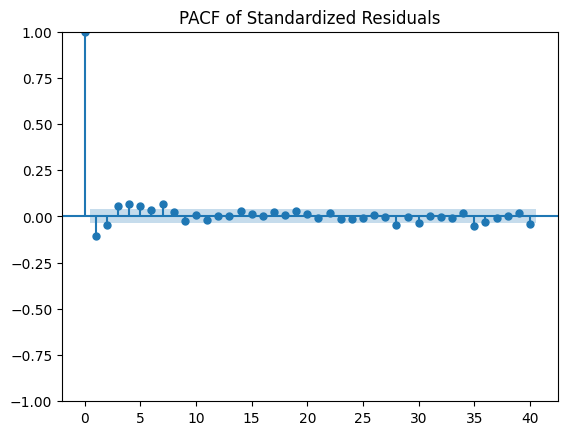

In [0]:
plot_pacf(standardized_residuals, lags=40)
plt.title('PACF of Standardized Residuals')
plt.show()

Parámetros Principales
- **y**: La serie temporal a la que se ajustará el modelo ARIMA. Este es un parámetro obligatorio.
- **exogenous**: Un array opcional de variables exógenas (predictoras) para el modelo. Debe tener la misma longitud que y. 
- **seasonal**: (booleano, por defecto True) Si se debe ajustar un modelo ARIMA estacional.
- **m**: (entero, por defecto 1) El número de períodos en una temporada completa. Por ejemplo, m=12 para datos mensuales si esperas un patrón anual.
- **d**: (entero o None) El orden de diferenciación. Si es None, se determinará automáticamente usando pruebas estadísticas.
- **D**: (entero o None) El orden de diferenciación estacional. Si es None, se determinará automáticamente usando pruebas estadísticas.
- start_p: (entero, por defecto 2) El valor inicial de p en la búsqueda grid (AR).
- start_q: (entero, por defecto 2) El valor inicial de q en la búsqueda grid (MA).
- max_p: (entero, por defecto 5) El valor máximo de p en la búsqueda grid.
- max_q: (entero, por defecto 5) El valor máximo de q en la búsqueda grid.
- start_P: (entero, por defecto 1) El valor inicial de P en la búsqueda grid (SAR).
- start_Q: (entero, por defecto 1) El valor inicial de Q en la búsqueda grid (SMA).
- max_P: (entero, por defecto 2) El valor máximo de P en la búsqueda grid.
- max_Q: (entero, por defecto 2) El valor máximo de Q en la búsqueda grid.
- max_d: (entero, por defecto 2) El valor máximo de d en la búsqueda grid.
- max_D: (entero, por defecto 1) El valor máximo de D en la búsqueda grid.
- **seasonal_test**: (string, por defecto 'ocsb') El nombre de la prueba estadística que se utilizará para determinar la estacionalidad. Puede ser 'ocsb' o 'ch'.
- stepwise: (booleano, por defecto True) Si se debe utilizar un procedimiento stepwise (paso a paso) para la búsqueda de parámetros. Esto puede hacer que la búsqueda sea más rápida.
- n_jobs: (entero, por defecto 1) El número de trabajos (hilos) a ejecutar en paralelo para la búsqueda de parámetros. Utilizar -1 para usar todos los procesadores disponibles.
- max_order: (entero, por defecto 5) La suma máxima de p, d, q, P, D y Q. Este parámetro se usa para limitar la complejidad del modelo.
- information_criterion: (string, por defecto 'aic') El criterio de información que se utilizará para comparar modelos. Puede ser 'aic', 'bic', 'hqic', etc.
- trace: (booleano, por defecto False) Si se debe imprimir la salida de la búsqueda de parámetros.
- error_action: (string, por defecto 'warn') Qué hacer si hay un error al ajustar un modelo. Las opciones incluyen 'warn', 'ignore', 'raise' y 'trace'.
- suppress_warnings: (booleano, por defecto False) Si se deben suprimir las advertencias de pmdarima.
- random: (booleano, por defecto False) Si se debe realizar una búsqueda aleatoria en lugar de una búsqueda grid completa.
- **random_state**: (entero o None) La semilla para la búsqueda aleatoria.
- n_fits: (entero, por defecto 10) El número de modelos que se ajustarán si random=True.

In [0]:
# Extrae la serie temporal
ts = pdf['count']

# Aplica auto_arima para encontrar los mejores parámetros
model = pm.auto_arima(ts, seasonal=False, stepwise=True)

# Resumen del modelo
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5088
Model:               SARIMAX(4, 0, 0)   Log Likelihood              -31850.919
Date:                Sun, 14 Jul 2024   AIC                          63713.837
Time:                        10:06:05   BIC                          63753.045
Sample:                             0   HQIC                         63727.567
                               - 5088                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    155.9062      4.719     33.035      0.000     146.656     165.156
ar.L1          0.0560      0.014      3.986      0.000       0.028       0.084
ar.L2         -0.0180      0.014     -1.285      0.1

In [0]:
# Realiza un pronóstico de los próximos 10 períodos
forecast, conf_int = model.predict(n_periods=4, return_conf_int=True)

# Crear un DataFrame de pandas con los resultados
future_dates = pd.date_range(start=ts.index[-1], periods=4, freq='D')
forecast_df = pd.DataFrame({'date': future_dates, 'forecast': forecast, 'lower_ci': conf_int[:, 0], 'upper_ci': conf_int[:, 1]})

# Convertir de nuevo a un DataFrame de PySpark
forecast_spark_df = spark.createDataFrame(forecast_df)

# Mostrar el DataFrame de PySpark con los resultados del pronóstico
forecast_spark_df.show()


+-------------------+------------------+-------------------+------------------+
|               date|          forecast|           lower_ci|          upper_ci|
+-------------------+------------------+-------------------+------------------+
|2019-02-20 21:15:00|138.93028424664448|-109.22979105282548| 387.0903595461144|
|2019-02-21 21:15:00| 148.9681014464682|  -99.5813913287129|397.51759422164935|
|2019-02-22 21:15:00|151.61889585578533| -96.95805652347309|400.19584823504374|
|2019-02-23 21:15:00|158.54794704428656| -90.06160879033064|407.15750287890376|
+-------------------+------------------+-------------------+------------------+



/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [0]:
display(forecast_spark_df)

date forecast lower_ci upper_ci 2019-02-20T21:15:00Z 138.93028424664448 -109.22979105282548 387.0903595461144 2019-02-21T21:15:00Z 148.9681014464682 -99.5813913287129 397.51759422164935 2019-02-22T21:15:00Z 151.61889585578533 -96.95805652347309 400.19584823504374 2019-02-23T21:15:00Z 158.54794704428656 -90.06160879033064 407.15750287890376

In [0]:
import pmdarima as pm
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Supongamos que 'data' es tu serie temporal original
# data = pd.Series(...)  # Tu serie temporal aquí

# Aplicar la transformación de Box-Cox
data_boxcox, lambda_ = boxcox(data)
print(f'Transformación de Box-Cox aplicada con lambda = {lambda_}')

# Ajustar el modelo auto_arima a los datos transformados
model = pm.auto_arima(data_boxcox, seasonal=False, stepwise=True, suppress_warnings=True)

# Residuos del modelo
residuals = model.resid()

# Realizar la prueba de Shapiro-Wilk en los residuos transformados
from scipy.stats import shapiro

shapiro_test_stat, shapiro_p_value = shapiro(residuals)
print(f'Shapiro-Wilk Test (Residuos Transformados): Statistic={shapiro_test_stat}, p-value={shapiro_p_value}')

# Plot Q-Q para los residuos transformados
qqplot(residuals, line='s')
plt.title('Q-Q Plot de los Residuos Transformados')
plt.show()

# Realizar la prueba de Ljung-Box nuevamente en los residuos transformados
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

residuals_series = pd.Series(residuals)
ljung_box_result = acorr_ljungbox(residuals_series, lags=[10], return_df=True)
print(ljung_box_result)


### Modelo GARCH prueba 1

In [0]:

import numpy as np
from arch import arch_model

# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]
    
    # Ajustar el modelo GARCH(1,1)
    model = arch_model(train_data, vol='Garch', p=1, q=2) #rescale=False
    model_fit = model.fit(disp='off')
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    forecast = model_fit.forecast(horizon=prediction_interval)
    pred = forecast.mean.iloc[-1].values
    
    # Agregar predicciones a la lista
    predictions.extend(pred)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")




/local_disk0/.ephemeral_nfs/envs/pythonEnv-c51e0a23-fe2b-465b-b41c-f486624f5e15/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.596e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-c51e0a23-fe2b-465b-b41c-f486624f5e15/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.596e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing t

In [0]:
import numpy as np
from arch import arch_model

# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]

    offset = 0.1
    train_data_adjusted = train_data + offset
    
    # Calcular retornos logarítmicos
    log_returns = np.log(train_data_adjusted).diff().dropna()

    # Asegurarse de que no hay NaNs
    #log_returns = log_returns.dropna()
    
    # Escalar los retornos
    scaling_factor = 10
    scaled_returns = log_returns * scaling_factor
    
    # Ajustar el modelo GARCH(1,2) a los retornos escalados
    model = arch_model(scaled_returns, vol='Garch', p=1, q=2)
    model_fit = model.fit(disp='off')
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    forecast = model_fit.forecast(horizon=prediction_interval)
    pred_scaled = forecast.mean.iloc[-1].values / scaling_factor  # Desescalar la predicción
    
    # Convertir los retornos predichos de regreso a count
    last_count = train_data_adjusted.iloc[-1]
    pred_count = last_count * np.exp(pred_scaled) - offset  # Ajustar por el offset
    
    # Agregar predicciones a la lista
    predictions.extend(pred_count)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")


In [0]:
display(result_df)

street date month week_of_year day_of_month day_of_week weekend time hour minutes time_period count speed predictions 1593 2019-02-01 2 5 1 6 0 00:00:00 0 0 night 38 86.98684 null 1593 2019-02-01 2 5 1 6 0 00:15:00 0 15 night 63 85.8836 null 1593 2019-02-01 2 5 1 6 0 00:30:00 0 30 night 69 86.86715 null 1593 2019-02-01 2 5 1 6 0 00:45:00 0 45 night 50 85.87666 null 1593 2019-02-01 2 5 1 6 0 01:00:00 1 0 night 46 87.134056 null 1593 2019-02-01 2 5 1 6 0 01:15:00 1 15 night 55 82.6303 null 1593 2019-02-01 2 5 1 6 0 01:30:00 1 30 night 63 81.478836 null 1593 2019-02-01 2 5 1 6 0 01:45:00 1 45 night 58 84.083336 null 1593 2019-02-01 2 5 1 6 0 02:00:00 2 0 night 48 83.73055 null 1593 2019-02-01 2 5 1 6 0 02:15:00 2 15 night 86 84.800385 null 1593 2019-02-01 2 5 1 6 0 02:30:00 2 30 night 69 85.30193 null 1593 2019-02-01 2 5 1 6 0 02:45:00 2 45 night 51 84.745094 null 1593 2019-02-01 2 5 1 6 0 03:00:00 3 0 night 80 83.11875 null 1593 2019-02-01 2 5 1 6 0 03:15:00 3 15 night 110 81.57576 null 1593 2019-02-01 2 5 1 6 0 03:30:00 3 30 night 185 81.87027 null 1593 2019-02-01 2 5 1 6 0 03:45:00 3 45 night 147 82.774376 null 1593 2019-02-01 2 5 1 6 0 04:00:00 4 0 night 186 85.49462 null 1593 2019-02-01 2 5 1 6 0 04:15:00 4 15 night 251 84.63546 null 1593 2019-02-01 2 5 1 6 0 04:30:00 4 30 night 273 85.07509 null 1593 2019-02-01 2 5 1 6 0 04:45:00 4 45 night 250 85.664 null 1593 2019-02-01 2 5 1 6 0 05:00:00 5 0 night 292 84.10388 null 1593 2019-02-01 2 5 1 6 0 05:15:00 5 15 night 325 83.57333 null 1593 2019-02-01 2 5 1 6 0 05:30:00 5 30 night 293 83.01365 null 1593 2019-02-01 2 5 1 6 0 05:45:00 5 45 night 292 81.9589 null 1593 2019-02-01 2 5 1 6 0 06:00:00 6 0 morning 266 81.36591 null 1593 2019-02-01 2 5 1 6 0 06:15:00 6 15 morning 234 79.23006 null 1593 2019-02-01 2 5 1 6 0 06:30:00 6 30 morning 220 78.69242 null 1593 2019-02-01 2 5 1 6 0 06:45:00 6 45 morning 249 79.015396 null 1593 2019-02-01 2 5 1 6 0 07:00:00 7 0 morning 237 79.78622 null 1593 2019-02-01 2 5 1 6 0 07:15:00 7 15 morning 225 80.345924 null 1593 2019-02-01 2 5 1 6 0 07:30:00 7 30 morning 254 81.05249 null 1593 2019-02-01 2 5 1 6 0 07:45:00 7 45 morning 216 82.90278 null 1593 2019-02-01 2 5 1 6 0 08:00:00 8 0 morning 288 82.07176 null 1593 2019-02-01 2 5 1 6 0 08:15:00 8 15 morning 290 82.36379 null 1593 2019-02-01 2 5 1 6 0 08:30:00 8 30 morning 299 82.26868 null 1593 2019-02-01 2 5 1 6 0 08:45:00 8 45 morning 370 80.320724 null 1593 2019-02-01 2 5 1 6 0 09:00:00 9 0 morning 342 81.72855 null 1593 2019-02-01 2 5 1 6 0 09:15:00 9 15 morning 354 80.085686 null 1593 2019-02-01 2 5 1 6 0 09:30:00 9 30 morning 356 75.862595 null 1593 2019-02-01 2 5 1 6 0 09:45:00 9 45 morning 380 74.001755 null 1593 2019-02-01 2 5 1 6 0 10:00:00 10 0 morning 387 71.24419 null 1593 2019-02-01 2 5 1 6 0 10:15:00 10 15 morning 379 71.69657 null 1593 2019-02-01 2 5 1 6 0 10:30:00 10 30 morning 400 75.64687 null 1593 2019-02-01 2 5 1 6 0 10:45:00 10 45 morning 379 80.763855 null 1593 2019-02-01 2 5 1 6 0 11:00:00 11 0 morning 383 80.45779 null 1593 2019-02-01 2 5 1 6 0 11:15:00 11 15 morning 324 80.96965 null 1593 2019-02-01 2 5 1 6 0 11:30:00 11 30 morning 368 79.821106 null 1593 2019-02-01 2 5 1 6 0 11:45:00 11 45 morning 363 79.352844 null 1593 2019-02-01 2 5 1 6 0 12:00:00 12 0 afternoon 322 80.88768 null 1593 2019-02-01 2 5 1 6 0 12:15:00 12 15 afternoon 315 79.814285 null 1593 2019-02-01 2 5 1 6 0 12:30:00 12 30 afternoon 337 82.04945 null 1593 2019-02-01 2 5 1 6 0 12:45:00 12 45 afternoon 329 81.598274 null 1593 2019-02-01 2 5 1 6 0 13:00:00 13 0 afternoon 316 68.415085 null 1593 2019-02-01 2 5 1 6 0 13:15:00 13 15 afternoon 335 72.254974 null 1593 2019-02-01 2 5 1 6 0 13:30:00 13 30 afternoon 311 74.30091 null 1593 2019-02-01 2 5 1 6 0 13:45:00 13 45 afternoon 288 57.011806 null 1593 2019-02-01 2 5 1 6 0 14:00:00 14 0 afternoon 287 55.124157 null 1593 2019-02-01 2 5 1 6 0 14:15:00 14 15 afternoon 250 52.414932 null 1593 2019-02-01 2 5 1 6 0 14:30:00 14 30 afternoon 247 57.0361 null 1593 20

Agregar el Offset Antes de Convertir a Retornos Logarítmicos:
El offset se suma a los datos para evitar valores no positivos. Asegúrate de que el offset también se maneje correctamente cuando realices las predicciones.

Convertir los Retornos Logarítmicos Predichos de Regreso a los Valores Originales:
Para convertir los retornos logarítmicos de regreso a los valores originales, necesitas tener en cuenta el offset que agregaste al principio.

Escalado y Desescalado:
Escalas los retornos logarítmicos antes de ajustar el modelo y desescala las predicciones después del pronóstico.

Conversión a count:
Después de obtener las predicciones en términos de retornos logarítmicos escalados, conviértelas de vuelta a los valores originales usando el último valor del count ajustado y ajustando por el offset.
Índice de Predicciones:

Asegúrate de que el índice de pred_df coincida con el índice del DataFrame original para que la unión sea correcta.

In [0]:
# Resumen del ajuste del modelo
print(model_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  count   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1420.76
Distribution:                  Normal   AIC:                           2851.51
Method:            Maximum Likelihood   BIC:                           2874.06
                                        No. Observations:                  671
Date:                Sun, Jul 21 2024   Df Residuals:                      670
Time:                        17:43:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0126  7.582e-02     -0.166      0.868 [ -0.161,  0.13

In [0]:
from sklearn.metrics import mean_squared_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(pdf["count"].iloc[window_size:window_size+len(predictions)], predictions))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 41.02036873527787


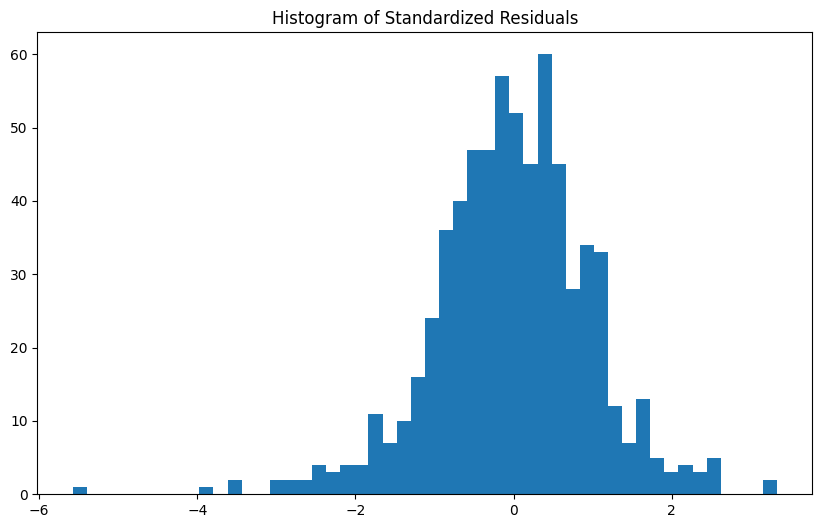

In [0]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Obtener residuos estandarizados
standardized_residuals = model_fit.resid / model_fit.conditional_volatility

# Histograma de residuos estandarizados
plt.figure(figsize=(10, 6))
plt.hist(standardized_residuals, bins=50)
plt.title('Histogram of Standardized Residuals')
plt.show()




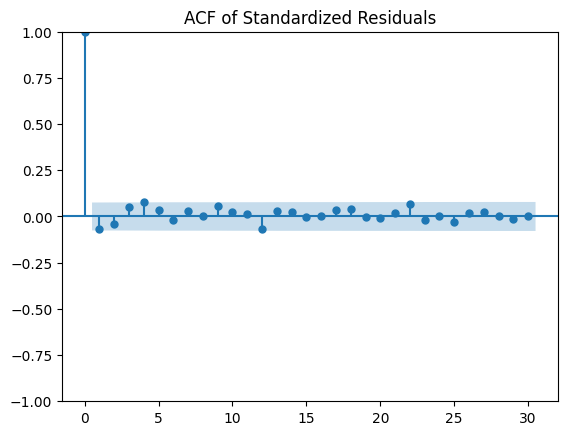

In [0]:
# ACF y PACF de residuos estandarizados
plot_acf(standardized_residuals, lags=30)
plt.title('ACF of Standardized Residuals')
plt.show()



/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


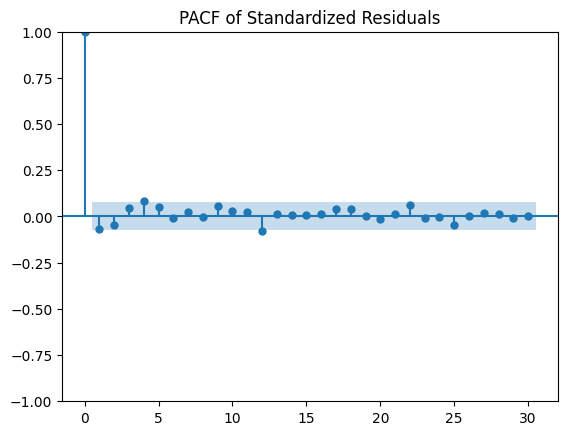

In [0]:
plot_pacf(standardized_residuals, lags=30)
plt.title('PACF of Standardized Residuals')
plt.show()

In [0]:
from statsmodels.stats.diagnostic import het_arch

# Prueba de Engle
arch_test = het_arch(standardized_residuals)
print(f'Engle test p-value: {arch_test[1]}')


Engle test p-value: 0.8291915560691054


### GARCH con mean ARX

In [0]:
import numpy as np
from arch import arch_model

# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]

    offset = 0.1
    train_data_adjusted = train_data + offset
    
    # Calcular retornos logarítmicos
    log_returns = np.log(train_data_adjusted).diff().dropna()

    # Asegurarse de que no hay NaNs
    #log_returns = log_returns.dropna()
    
    # Escalar los retornos
    scaling_factor = 10
    scaled_returns = log_returns * scaling_factor
    
    # Ajustar el modelo GARCH(1,1) a los retornos escalados
    model = arch_model(scaled_returns, vol='Garch', mean='ARX', p=1, q=2)
    model_fit = model.fit(disp='off')
    
    # Hacer predicción para el siguiente intervalo de 1 hora
    forecast = model_fit.forecast(horizon=prediction_interval)
    pred_scaled = forecast.mean.iloc[-1].values / scaling_factor  # Desescalar la predicción
    
    # Convertir los retornos predichos de regreso a count
    last_count = train_data_adjusted.iloc[-1]
    pred_count = last_count * np.exp(pred_scaled) - offset  # Ajustar por el offset
    
    # Agregar predicciones a la lista
    predictions.extend(pred_count)

# Convertir predicciones a DataFrame de pandas
pred_garch = pd.DataFrame(predictions, index=pdf.index[window_size:window_size+len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_garch = pdf.join(pred_garch, how="left")


In [0]:
# Resumen del ajuste del modelo
print(model_fit.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  count   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1420.76
Distribution:                  Normal   AIC:                           2851.51
Method:            Maximum Likelihood   BIC:                           2874.06
                                        No. Observations:                  671
Date:                Sun, Jul 21 2024   Df Residuals:                      670
Time:                        18:00:11   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         -0.0126  7.582e-02     -0.166      0.868 [ -0.161,  0.13

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcular RMSE
mse = np.sqrt(mean_squared_error(
    pdf["count"].iloc[window_size:window_size + len(predictions)], 
    predictions
))
mae = mean_absolute_error(
    pdf["count"].iloc[window_size:window_size + len(predictions)], 
    predictions
)
r2 = r2_score(
    pdf["count"].iloc[window_size:window_size + len(predictions)], 
    predictions
)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 41.019582090951495
Mean Absolute Error (MAE): 26.686690044921303
R-squared (R2): 0.895569813769839


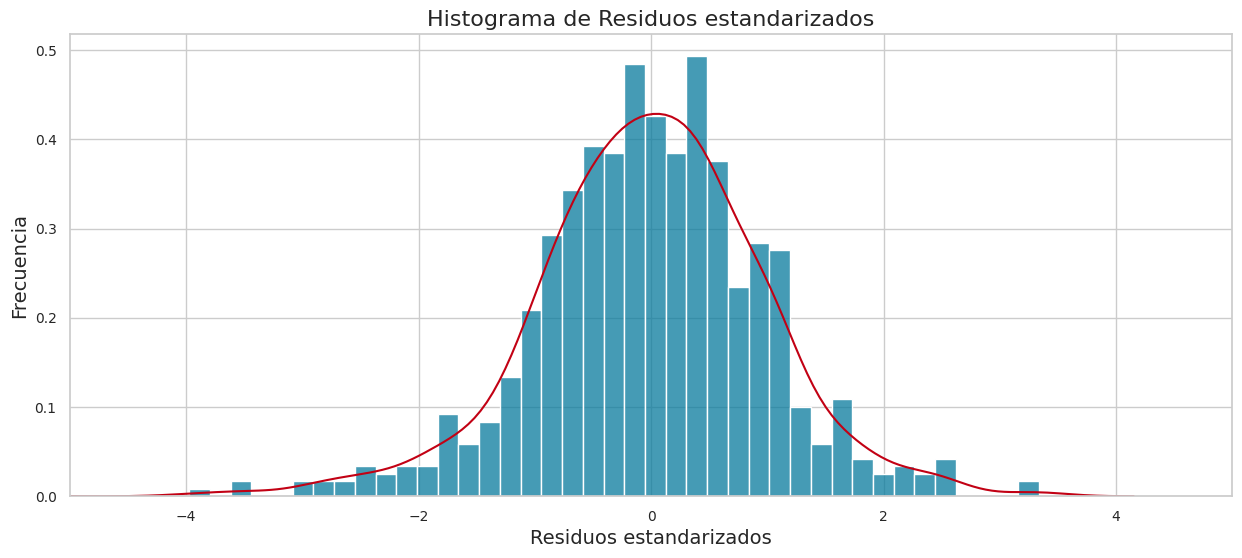

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Obtener residuos estandarizados
standardized_residuals = model_fit.resid / model_fit.conditional_volatility

# Histograma de residuos estandarizados
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(15, 6))

# Crear el histograma con la curva KDE
sns.histplot(standardized_residuals, bins=50, color='#077A9D', kde=False, stat='density')
sns.kdeplot(standardized_residuals, color='#C20114')

# Limitar los rangos de X
plt.xlim(-5, 5)

# Agregar títulos y etiquetas
plt.title('Histograma de Residuos estandarizados', fontsize=16)
plt.xlabel('Residuos estandarizados', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar la gráfica
plt.show()

Text(0, 0.5, 'Autocorrelación')

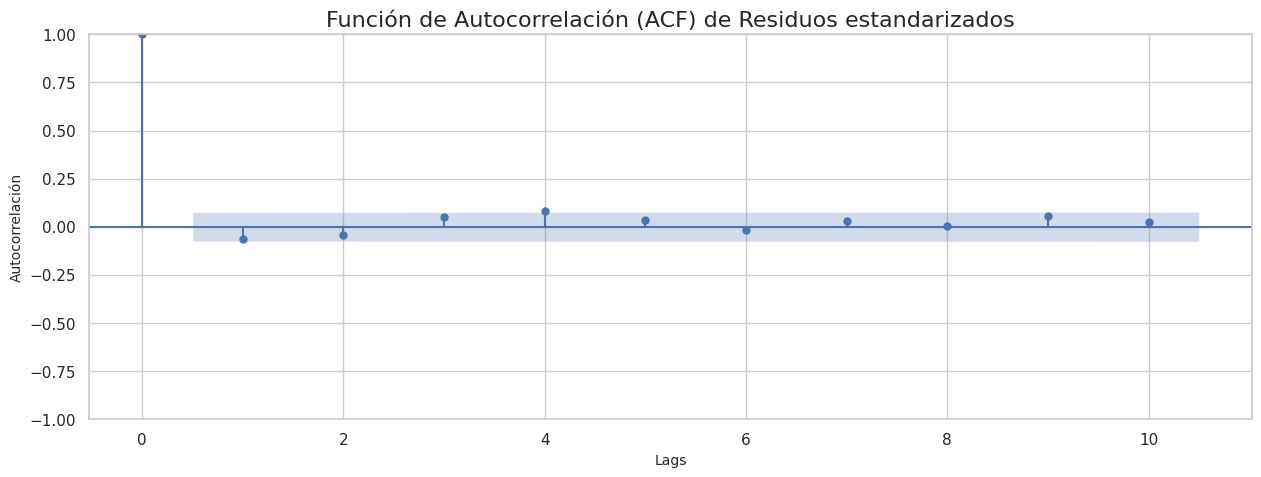

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF de retornos al cuadrado para seleccionar p y q

# Generar el correlograma
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(standardized_residuals, lags=10, ax=ax)

ax.set_title('Función de Autocorrelación (ACF) de Residuos estandarizados', fontsize=16)
ax.set_xlabel('Lags', fontsize=10)
ax.set_ylabel('Autocorrelación', fontsize=10)

/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Autocorrelación Parcial')

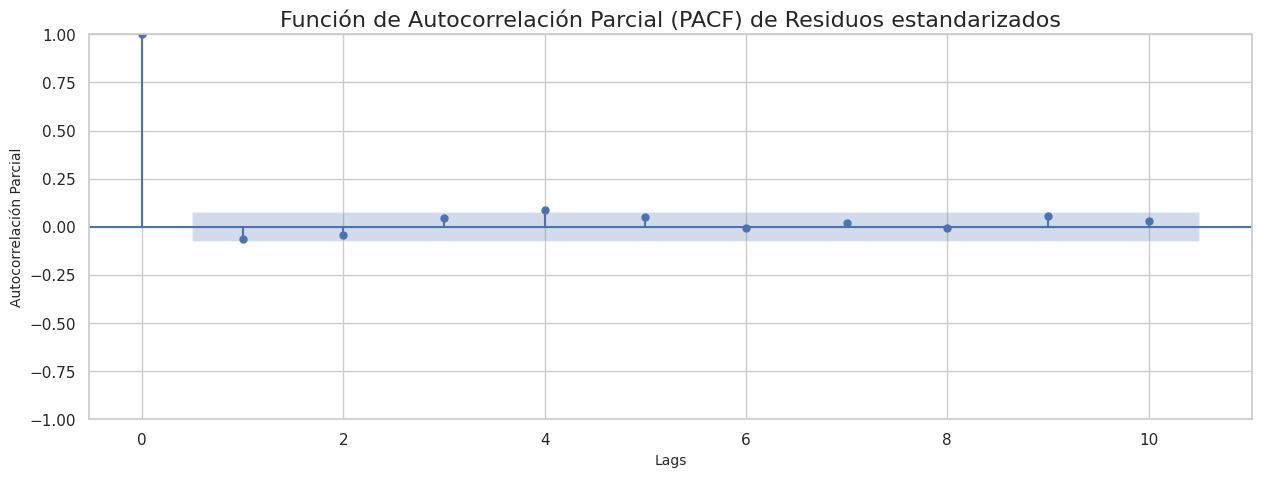

In [0]:
# Generar el correlograma
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(standardized_residuals, lags=10, ax=ax)

ax.set_title('Función de Autocorrelación Parcial (PACF) de Residuos estandarizados', fontsize=16)
ax.set_xlabel('Lags', fontsize=10)
ax.set_ylabel('Autocorrelación Parcial', fontsize=10)

In [0]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(standardized_residuals, model_fit.conditional_volatility)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-4354897052404567>, line 2
      1 from statsmodels.stats.diagnostic import het_breuschpagan
----> 2 bp_test = het_breuschpagan(standardized_residuals, model_fit.conditional_volatility)

File /databricks/python/lib/python3.10/site-packages/statsmodels/stats/diagnostic.py:810, in het_breuschpagan(resid, exog_het, robust)
    808 if not robust:
    809     y = y / np.mean(y)
--> 810 nobs, nvars = x.shape
    811 resols = OLS(y, x).fit()
    812 fval = resols.fvalue

ValueError: not enough values to unpack (expected 2, got 1)

### GARCH con mean ARX y exogenous = speed

In [0]:
import numpy as np
import pandas as pd
from arch import arch_model

# Crear listas para almacenar predicciones
predictions = []

# Definir la ventana de una semana y el intervalo de predicción (1 hora)
window_size = 7 * 24 * 4  # Una semana de datos con intervalos de 15 minutos
prediction_interval = 4  # 1 hora de datos con intervalos de 15 minutos

# Recorrer los datos en ventanas deslizantes
for end in range(window_size, len(pdf), prediction_interval):
    start = end - window_size
    train_data = pdf.iloc[start:end]["count"]
    train_data_speed = pdf.iloc[start:end]["speed"]

    offset = 0.1
    train_data_adjusted = train_data + offset
    
    # Calcular retornos logarítmicos
    log_returns = np.log(train_data_adjusted).diff().dropna()
    train_data_speed = train_data_speed[1:]  # Ajustar tamaño de train_data_speed

    # Sincronizar los índices de log_returns y train_data_speed
    log_returns, train_data_speed = log_returns.align(train_data_speed, join='inner')

    # Escalar los retornos
    scaling_factor = 10
    scaled_returns = log_returns * scaling_factor
    
    # Ajustar el modelo GARCH(1,2) a los retornos escalados con la variable externa
    model = arch_model(scaled_returns, vol='Garch', mean='ARX', p=1, q=2, x=train_data_speed.values.reshape(-1, 1))
    model_fit = model.fit(disp='off')
    
    # Obtener las últimas observaciones de speed para el horizonte de predicción
    future_speed = pdf.iloc[end:end + prediction_interval]["speed"].values.reshape(-1, 1)
    future_speed_list = future_speed.flatten().tolist()

    # Hacer predicción para el siguiente intervalo de 1 hora
    forecast = model_fit.forecast(horizon=prediction_interval, x=future_speed_list)
    
    # Ajustar predicciones con datos exógenos futuros
    mean_forecast = forecast.mean.iloc[-prediction_interval:].values.flatten()
    pred_scaled = mean_forecast / scaling_factor  # Desescalar la predicción
    
    # Convertir los retornos predichos de regreso a count
    last_count = train_data_adjusted.iloc[-1]
    pred_count = last_count * np.exp(pred_scaled) - offset  # Ajustar por el offset
    
    # Agregar predicciones a la lista
    predictions.extend(pred_count)

# Convertir predicciones a DataFrame de pandas
pred_df = pd.DataFrame(predictions, index=pdf.index[window_size:window_size + len(predictions)], columns=["predictions"])

# Unir las predicciones con los datos originales
result_df = pdf.join(pred_df, how="left")



                    street        date  month  ...  count      speed  predictions
datetime_full                                  ...                               
2019-01-07 00:00:00   1593  2019-01-07      1  ...   21.1  87.849205          NaN
2019-01-07 00:15:00   1593  2019-01-07      1  ...   24.1  87.708336          NaN
2019-01-07 00:30:00   1593  2019-01-07      1  ...   21.1  87.142860          NaN
2019-01-07 00:45:00   1593  2019-01-07      1  ...   19.1  86.780701          NaN
2019-01-07 01:00:00   1593  2019-01-07      1  ...   21.1  87.785713          NaN
...                    ...         ...    ...  ...    ...        ...          ...
2019-02-28 22:45:00   1593  2019-02-28      2  ...   53.1  86.022011    61.467053
2019-02-28 23:00:00   1593  2019-02-28      2  ...   46.1  86.731888    54.422993
2019-02-28 23:15:00   1593  2019-02-28      2  ...   39.1  86.692307    54.419082
2019-02-28 23:30:00   1593  2019-02-28      2  ...   54.1  86.913582    54.440952
2019-02-28 23:45

In [0]:
# Resumen del ajuste del modelo
print(model_fit.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  count   R-squared:                       0.008
Mean Model:                      AR-X   Adj. R-squared:                  0.007
Vol Model:                      GARCH   Log-Likelihood:               -1407.06
Distribution:                  Normal   AIC:                           2826.12
Method:            Maximum Likelihood   BIC:                           2853.18
                                        No. Observations:                  671
Date:                Sun, Jul 28 2024   Df Residuals:                      669
Time:                        12:49:33   Df Model:                            2
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const         -1.3264      0.268     -4.951  7.396e-07    

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcular RMSE
mse = np.sqrt(mean_squared_error(
    pdf["count"].iloc[window_size:window_size + len(predictions)], 
    predictions
))
mae = mean_absolute_error(
    pdf["count"].iloc[window_size:window_size + len(predictions)], 
    predictions
)
r2 = r2_score(
    pdf["count"].iloc[window_size:window_size + len(predictions)], 
    predictions
)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 40.086306458147035
Mean Absolute Error (MAE): 26.09645354421867
R-squared (R2): 0.9002677368633948


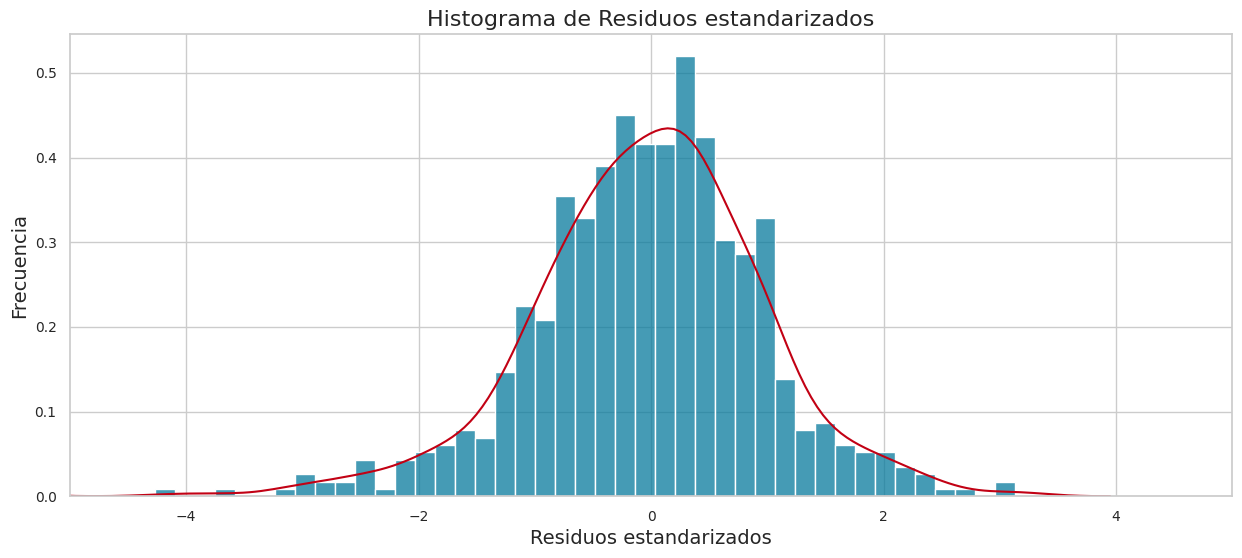

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Obtener residuos estandarizados
standardized_residuals = model_fit.resid / model_fit.conditional_volatility

# Histograma de residuos estandarizados
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(15, 6))

# Crear el histograma con la curva KDE
sns.histplot(standardized_residuals, bins=50, color='#077A9D', kde=False, stat='density')
sns.kdeplot(standardized_residuals, color='#C20114')

# Limitar los rangos de X
plt.xlim(-5, 5)

# Agregar títulos y etiquetas
plt.title('Histograma de Residuos estandarizados', fontsize=16)
plt.xlabel('Residuos estandarizados', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar la gráfica
plt.show()

Text(0, 0.5, 'Autocorrelación')

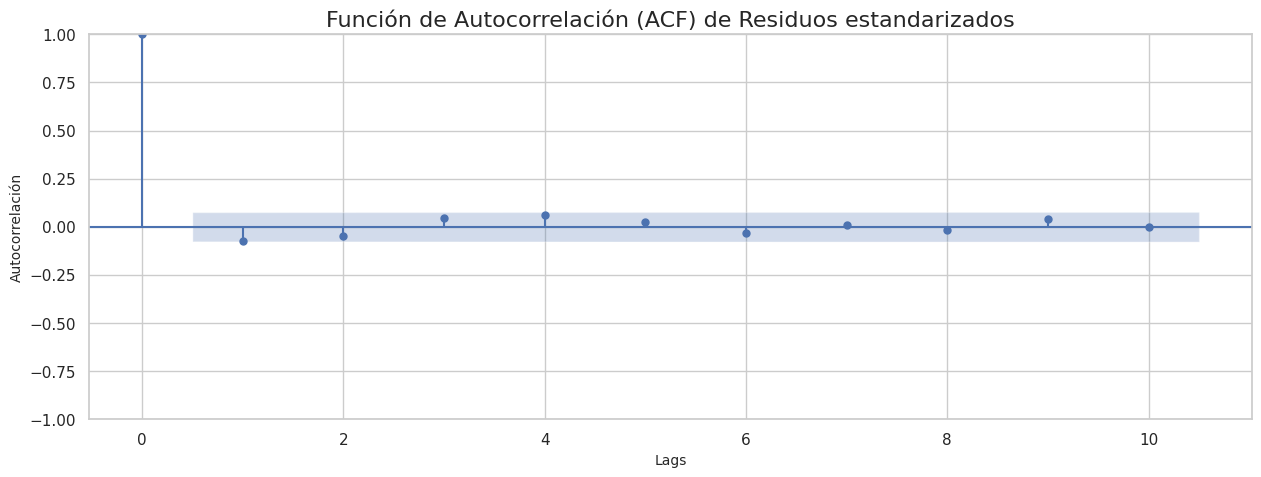

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF de retornos al cuadrado para seleccionar p y q

# Generar el correlograma
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(standardized_residuals, lags=10, ax=ax)

ax.set_title('Función de Autocorrelación (ACF) de Residuos estandarizados', fontsize=16)
ax.set_xlabel('Lags', fontsize=10)
ax.set_ylabel('Autocorrelación', fontsize=10)

/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Autocorrelación Parcial')

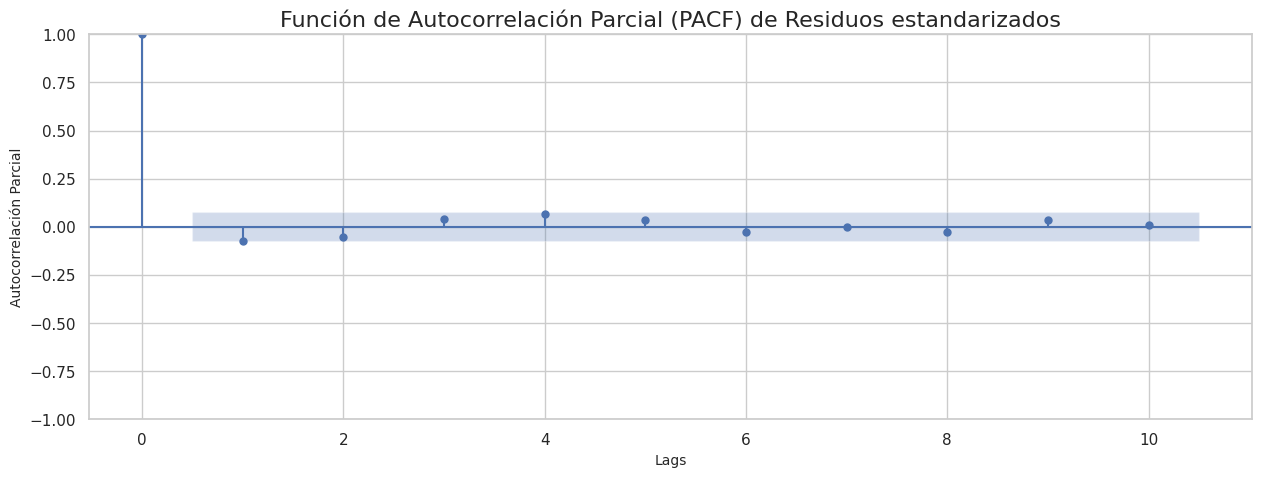

In [0]:
# Generar el correlograma
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(standardized_residuals, lags=10, ax=ax)

ax.set_title('Función de Autocorrelación Parcial (PACF) de Residuos estandarizados', fontsize=16)
ax.set_xlabel('Lags', fontsize=10)
ax.set_ylabel('Autocorrelación Parcial', fontsize=10)

### Redes LSTM

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Definir la función create_dataset
def create_dataset(series, timesteps=1, prediction_interval=4):
    X, y = [], []
    for i in range(len(series) - timesteps - prediction_interval + 1):
        X.append(series[i:(i + timesteps), 0])
        y.append(series[i + timesteps + prediction_interval - 1, 0])
    return np.array(X), np.array(y)

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pdf["count"].values.reshape(-1, 1))


### Redes LSTM - Optimización Bayesiana

In [0]:
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Paso 1: Preparar los datos
timesteps = 672  # Ventana de 2 semanas
prediction_interval = 4  # Predicción de 1 hora

# Crear el dataset para la LSTM
X, y = create_dataset(scaled_data, timesteps, prediction_interval)

# Reshape de los datos para LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], timesteps, 1))

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 2: Definir el modelo para la búsqueda
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=16),
                   return_sequences=True, 
                   input_shape=(timesteps, 1)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=16)))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error')
    
    return model

# Paso 3: Configurar la optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',  # Minimiza el error de validación
    max_trials=10,  # Número de configuraciones de hiperparámetros a probar
    directory='bayesian_opt',
    project_name='lstm_optimization'
)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-18e9425a-1c02-4ccf-992e-71063be81663/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [0]:
# Paso 4: Realizar la búsqueda
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Paso 5: Obtener los mejores hiperparámetros y entrenar el modelo final
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
#model = tuner.hypermodel.build(best_hps)
#model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

print(f"Best number of units in first LSTM layer: {best_hps.get('units_1')}")
print(f"Best number of units in second LSTM layer: {best_hps.get('units_2')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 08m 55s]
val_loss: 0.0035414218436926603

Best val_loss So Far: 0.003135435748845339
Total elapsed time: 01h 25m 21s
Best number of units in first LSTM layer: 96
Best number of units in second LSTM layer: 48
Best learning rate: 0.005379471191869606


In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtén el historial completo de los resultados de las pruebas
all_trials = tuner.oracle.get_best_trials(num_trials=10)

# Listas para almacenar los datos
units_1 = []
units_2 = []
learning_rates = []
val_losses = []

# Extraer datos de cada prueba
for trial in all_trials:
    # Obtener los hiperparámetros de la prueba
    hyperparameters = trial.hyperparameters
    # Obtener las métricas de la prueba
    metrics = trial.metrics

    # Extraer los valores de los hiperparámetros
    units_1.append(hyperparameters.get('units_1'))
    units_2.append(hyperparameters.get('units_2'))
    learning_rates.append(hyperparameters.get('learning_rate'))
    
    # Extraer el valor de la métrica val_loss
    val_loss = trial.metrics.get_best_value('val_loss')
    val_losses.append(val_loss)

# Crear un DataFrame para los resultados
results_df = pd.DataFrame({
    'units_1': units_1,
    'units_2': units_2,
    'learning_rate': learning_rates,
    'val_loss': val_losses
})


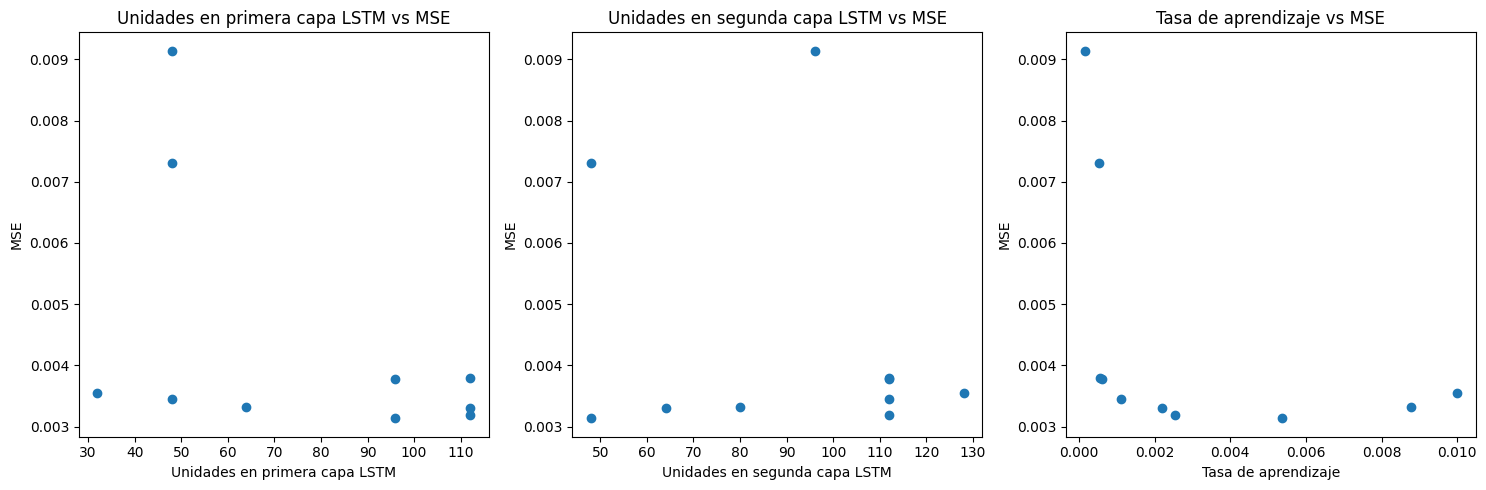

In [0]:
# Graficar los resultados
plt.figure(figsize=(15, 5))

# Gráfico de 'units_1' vs 'val_loss'
plt.subplot(1, 3, 1)
plt.scatter(results_df['units_1'], results_df['val_loss'])
plt.xlabel('Unidades en primera capa LSTM')
plt.ylabel('MSE')
plt.title('Unidades en primera capa LSTM vs MSE')

# Gráfico de 'units_2' vs 'val_loss'
plt.subplot(1, 3, 2)
plt.scatter(results_df['units_2'], results_df['val_loss'])
plt.xlabel('Unidades en segunda capa LSTM')
plt.ylabel('MSE')
plt.title('Unidades en segunda capa LSTM vs MSE')

# Gráfico de 'learning_rate' vs 'val_loss'
plt.subplot(1, 3, 3)
plt.scatter(results_df['learning_rate'], results_df['val_loss'])
plt.xlabel('Tasa de aprendizaje')
plt.ylabel('MSE')
plt.title('Tasa de aprendizaje vs MSE')

plt.tight_layout()
plt.show()

##Modelo LSTM con best model

In [0]:
from keras.optimizers import Adam

# 1) Definir dataset
timesteps = 672
prediction_interval = 4
X, y = create_dataset(scaled_data, timesteps, prediction_interval)

# Reshape de los datos para LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], timesteps, 1))

# 2) definir el modelo LSTM
# Definir el optimizador Adam con el learning rate óptimo
optimizer = Adam(learning_rate=0.00534)

# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(96, return_sequences=True, input_shape=(timesteps, 1)))
model.add(LSTM(48))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

# 3) Entrenar el modelo
model_lstm = model.fit(X, y, epochs=10, batch_size=4, validation_split=0.2, verbose=1)

# 4) Hacer predicciones
predictions = model.predict(X)

# Desescalar las predicciones
predictions = scaler.inverse_transform(predictions)

# Crear un índice para las predicciones
pred_index = pdf.index[timesteps + prediction_interval - 1: timesteps + prediction_interval - 1 + len(predictions)]

# Convertir las predicciones a DataFrame de pandas
pred_lstm = pd.DataFrame(predictions, index=pred_index, columns=["predictions"])

# Unir las predicciones con los datos originales
result_lstm = pdf.join(pred_lstm, how="left")

Epoch 1/10


/local_disk0/.ephemeral_nfs/envs/pythonEnv-18e9425a-1c02-4ccf-992e-71063be81663/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)




*** WARNING: max output size exceeded, skipping output. ***

883/883 ━━━━━━━━━━━━━━━━━━━━ 241s 272ms/step - loss: 0.0041 - val_loss: 0.0039
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step


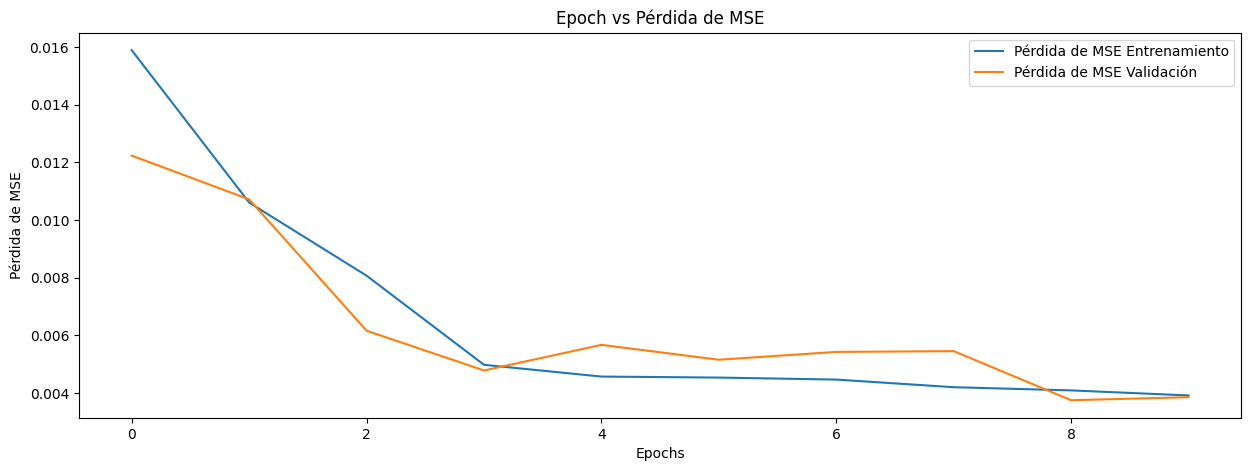

In [0]:
# Entrenar el modelo
#model_lstm = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_split=0.2, verbose=1)

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(15, 5))
plt.plot(model_lstm.history['loss'], label='Pérdida de MSE Entrenamiento')
if 'val_loss' in model_lstm.history:
    plt.plot(model_lstm.history['val_loss'], label='Pérdida de MSE Validación')
plt.title('Epoch vs Pérdida de MSE')
plt.xlabel('Epochs')
plt.ylabel('Pérdida de MSE')
plt.legend()
plt.show()



In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Elimina filas con NaN
result_lstm_clean = result_lstm.dropna(subset=['count', 'predictions'])

# Calcular métricas con los datos limpios
mse = mean_squared_error(result_lstm_clean['count'], result_lstm_clean['predictions'])
mae = mean_absolute_error(result_lstm_clean['count'], result_lstm_clean['predictions'])
r2 = r2_score(result_lstm_clean['count'], result_lstm_clean['predictions'])

# Imprimir resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 800.6696096855311
Mean Absolute Error (MAE): 18.616731509042925
R-squared (R2): 0.9503031268205974


In [0]:
import matplotlib.pyplot as plt


# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(result_lstm['count'], label='Original')
plt.plot(result_lstm['predictions'], label='Predicciones', color='red')
plt.legend()
plt.show()


### Combinación de predicciones: AR-GARCH + LSTM

In [0]:
#Rename columns
result_garch = result_garch.rename(columns={
    "predictions": "pred_garch"
})

result_lstm = result_lstm.rename(columns={
    "street": "street_lstm",
    "datetime": "datetime_lstm",
    "predictions": "pred_lstm"
})

result_lstm = result_lstm[["street_lstm", "datetime_lstm", "pred_lstm"]]

result_comb = result_garch.merge(
    result_lstm,
    left_on=['street', 'datetime_full'],
    right_on=['street_lstm', 'datetime_lstm'],
    how='left'
)

#Merge results
result_comb = result_comb.drop(columns=['street_lstm', 'datetime_lstm'])

#Calculate combination
# Simple avg
result_comb['pred_comb'] = (result_comb['pred_garch'] + result_comb['pred_lstm']) / 2

# Pond average by r2
r2_garch= 0.895569813769839
r2_lstm= 0.9503031268205974
total_r2 = r2_garch + r2_lstm
result_comb['pred_comb_pond_r2'] = ((result_comb['pred_garch'] * r2_garch) + (result_comb['pred_lstm'] * r2_lstm)) / total_r2

# Pond average by mse
mse_garch= 1/41.019582090951495
mse_lstm= 1/800.6696096855311
total_mse = mse_garch + mse_lstm
result_comb['pred_comb_pond_mse'] = ((result_comb['pred_garch'] * mse_garch) + (result_comb['pred_lstm'] * mse_lstm)) / total_mse

# Pond average by mae
mae_garch= 1/26.686690044921303
mae_lstm= 1/18.616731509042925
total_mae = mae_garch + mae_lstm
result_comb['pred_comb_pond_mae'] = ((result_comb['pred_garch'] * mae_garch) + (result_comb['pred_lstm'] * mae_lstm)) / total_mae

# Diferencias absolutas
result_comb['pred_garch_diff'] = result_comb['pred_garch'] - result_comb['count']
result_comb['pred_lstm_diff'] = result_comb['pred_lstm'] - result_comb['count']
result_comb['pred_comb_diff'] = result_comb['pred_comb'] - result_comb['count']
result_comb['pred_comb_r2_diff'] = result_comb['pred_comb_pond_r2'] - result_comb['count']
result_comb['pred_comb_mse_diff'] = result_comb['pred_comb_pond_mse'] - result_comb['count']
result_comb['pred_comb_mae_diff'] = result_comb['pred_comb_pond_mae'] - result_comb['count']

In [0]:
display(result_comb)

street date month week_of_year day_of_month day_of_week weekend time hour minutes time_period count speed datetime pred_garch pred_lstm pred_comb pred_comb_pond_r2 pred_comb_pond_mse pred_comb_pond_mae pred_garch_diff pred_lstm_diff pred_comb_diff pred_comb_r2_diff pred_comb_mse_diff pred_comb_mae_diff 1593 2019-01-07 1 2 7 2 0 00:00:00 0 0 night 21 87.849205 2019-01-07T00:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 00:15:00 0 15 night 24 87.708336 2019-01-07T00:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 00:30:00 0 30 night 21 87.14286 2019-01-07T00:30:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 00:45:00 0 45 night 19 86.7807 2019-01-07T00:45:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 01:00:00 1 0 night 21 87.78571 2019-01-07T01:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 01:15:00 1 15 night 30 87.772224 2019-01-07T01:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 01:30:00 1 30 night 24 87.361115 2019-01-07T01:30:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 01:45:00 1 45 night 32 85.3125 2019-01-07T01:45:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 02:00:00 2 0 night 33 86.59091 2019-01-07T02:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 02:15:00 2 15 night 46 87.572464 2019-01-07T02:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 02:30:00 2 30 night 48 87.10069 2019-01-07T02:30:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 02:45:00 2 45 night 72 87.44213 2019-01-07T02:45:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 03:00:00 3 0 night 85 87.85294 2019-01-07T03:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 03:15:00 3 15 night 110 87.46364 2019-01-07T03:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 03:30:00 3 30 night 144 87.49884 2019-01-07T03:30:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 03:45:00 3 45 night 156 86.51495 2019-01-07T03:45:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 04:00:00 4 0 night 161 87.62008 2019-01-07T04:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 04:15:00 4 15 night 212 86.72091 2019-01-07T04:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 04:30:00 4 30 night 229 86.91557 2019-01-07T04:30:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 04:45:00 4 45 night 267 86.333336 2019-01-07T04:45:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 05:00:00 5 0 night 243 86.452675 2019-01-07T05:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 05:15:00 5 15 night 284 85.85065 2019-01-07T05:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 05:30:00 5 30 night 317 84.23765 2019-01-07T05:30:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 05:45:00 5 45 night 289 84.90427 2019-01-07T05:45:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 06:00:00 6 0 morning 270 84.24938 2019-01-07T06:00:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 06:15:00 6 15 morning 211 54.040062 2019-01-07T06:15:00Z null null null null null null null null null null null null 1593 2019-01-07 1 2 7 2 0 06:30:00 6 30 morning 138 10.503018 2019

In [0]:
result_comb_sp = spark.createDataFrame(result_comb)

result_comb_sp.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("default.result_comb")

In [0]:
from pyspark.sql.functions import col, to_timestamp

result_comb_sp = result_comb_sp.withColumn(
    'datetime', 
    to_timestamp(col('datetime'))
)

display(
    result_comb_sp.filter(
        (col('datetime') >= '2019-02-03T21:00:00.000+00:00') & 
        (col('datetime') <= '2019-02-10T23:45:00.000+00:00')
    )
)

street date month week_of_year day_of_month day_of_week weekend time hour minutes time_period count speed datetime pred_garch pred_lstm pred_comb pred_comb_pond_r2 pred_comb_pond_mse pred_comb_pond_mae pred_garch_diff pred_lstm_diff pred_comb_diff pred_comb_r2_diff pred_comb_mse_diff pred_comb_mae_diff 1593 2019-02-03 2 5 3 1 1 21:00:00 21 0 evening 21 86.74603 2019-02-03T21:00:00Z 22.811248083515988 37.641544 30.226396212778504 30.44626842959743 23.534000029403725 31.54726710407781 1.8112480835159879 16.641544342041016 9.226396212778504 9.446268429597431 2.5340000294037246 10.547267104077811 1593 2019-02-03 2 5 3 1 1 21:15:00 21 15 evening 36 86.46759 2019-02-03T21:15:00Z 22.811248083515988 32.210445 27.510846743784363 27.650198386277935 23.269316377774405 28.34799264659949 -13.188751916484012 -3.7895545959472656 -8.489153256215637 -8.349801613722065 -12.730683622225595 -7.65200735340051 1593 2019-02-03 2 5 3 1 1 21:30:00 21 30 evening 24 87.479164 2019-02-03T21:30:00Z 22.811248083515988 29.012783 25.91201556702655 26.003958481026267 23.113478853779718 26.464359538051696 -1.1887519164840121 5.012783050537109 1.9120155670265504 2.0039584810262667 -0.8865211462202822 2.4643595380516956 1593 2019-02-03 2 5 3 1 1 21:45:00 21 45 evening 31 85.58602 2019-02-03T21:45:00Z 22.811248083515988 25.99987 24.40555919190448 24.45283321256298 22.966644949357356 24.689555729263056 -8.188751916484012 -5.000129699707031 -6.59444080809552 -6.547166787437021 -8.033355050642644 -6.310444270736944 1593 2019-02-03 2 5 3 1 1 22:00:00 22 0 evening 24 85.86806 2019-02-03T22:00:00Z 30.762496001266257 23.201014 26.981754783164867 26.869649717103883 30.3939883956891 26.308286295792964 6.762496001266257 -0.7989864349365234 2.9817547831648668 2.869649717103883 6.3939883956890995 2.308286295792964 1593 2019-02-03 2 5 3 1 1 22:15:00 22 15 evening 21 87.03968 2019-02-03T22:15:00Z 30.762496001266257 30.136711 30.449603560935863 30.44032607143209 30.73199843857457 30.39386713526602 9.762496001266257 9.136711120605469 9.449603560935863 9.44032607143209 9.731998438574571 9.39386713526602 1593 2019-02-03 2 5 3 1 1 22:30:00 22 30 evening 25 86.486664 2019-02-03T22:30:00Z 30.762496001266257 28.115402 29.438949111472972 29.399703808875028 30.633490214631387 29.203183319798313 5.762496001266257 3.1154022216796875 4.438949111472972 4.399703808875028 5.6334902146313866 4.203183319798313 1593 2019-02-03 2 5 3 1 1 22:45:00 22 45 evening 21 88.190475 2019-02-03T22:45:00Z 30.762496001266257 32.75825 31.760373595725902 31.789962148263204 30.85975872316834 31.938126229628594 9.762496001266257 11.758251190185547 10.760373595725902 10.789962148263204 9.85975872316834 10.938126229628594 1593 2019-02-03 2 5 3 1 1 23:00:00 23 0 evening 27 87.40124 2019-02-03T23:00:00Z 20.830066652362046 31.337648 26.08385752204284 26.239641773654174 21.342151898690965 27.01972249258865 -6.169933347637954 4.337648391723633 -0.916142477957159 -0.7603582263458257 -5.657848101309035 0.019722492588648777 1593 2019-02-03 2 5 3 1 1 23:15:00 23 15 evening 26 88.3141 2019-02-03T23:15:00Z 20.830066652362046 28.99505 24.91255854132995 25.033611242531745 21.2279857873771 25.63977737779805 -5.169933347637954 2.9950504302978516 -1.0874414586700496 -0.9663887574682555 -4.772014212622899 -0.3602226222019489 1593 2019-02-03 2 5 3 1 1 23:30:00 23 30 evening 13 88.03846 2019-02-03T23:30:00Z 20.830066652362046 29.769867 25.299966797860712 25.43250704010857 21.265746216919784 26.096195802433343 7.830066652362046 16.769866943359375 12.299966797860712 12.432507040108572 8.265746216919784 13.096195802433343 1593 2019-02-03 2 5 3 1 1 23:45:00 23 45 evening 24 86.513885 2019-02-03T23:45:00Z 20.830066652362046 28.0107 24.420383439096064 24.526842598729974 21.18001362895672 25.05993096768027 -3.1699333476379543 4.010700225830078 0.4203834390960637 0.5268425987299743 -2.8199863710432815 1.0599309676802697 1593 2019-02-04 2 6 4 2 0 00:00:00 0 0 night 23 84.73913 2019-02-04T00:00:00Z 23.80815509747878 30.947832 27.37799360251136

Databricks visualization. Run in Databricks to view.

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Elimina filas con NaN
result_comb_clean = result_comb.dropna(subset=['count', 'pred_comb'])

# Calcular métricas con los datos limpios
mse = mean_squared_error(result_comb_clean['count'], result_comb_clean['pred_comb'])
mae = mean_absolute_error(result_comb_clean['count'], result_comb_clean['pred_comb'])
r2 = r2_score(result_comb_clean['count'], result_comb_clean['pred_comb'])

# Imprimir resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 876.109912181359
Mean Absolute Error (MAE): 19.66323255414077
R-squared (R2): 0.9456206122098287


In [0]:
# Elimina filas con NaN
result_comb_clean = result_comb.dropna(subset=['count', 'pred_comb_pond_r2'])

# Calcular métricas con los datos limpios
mse = mean_squared_error(result_comb_clean['count'], result_comb_clean['pred_comb_pond_r2'])
mae = mean_absolute_error(result_comb_clean['count'], result_comb_clean['pred_comb_pond_r2'])
r2 = r2_score(result_comb_clean['count'], result_comb_clean['pred_comb_pond_r2'])

# Imprimir resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 863.339023902135
Mean Absolute Error (MAE): 19.52930815564074
R-squared (R2): 0.9464132902477153


In [0]:
# Elimina filas con NaN
result_comb_clean = result_comb.dropna(subset=['count', 'pred_comb_pond_mse'])

# Calcular métricas con los datos limpios
mse = mean_squared_error(result_comb_clean['count'], result_comb_clean['pred_comb_pond_mse'])
mae = mean_absolute_error(result_comb_clean['count'], result_comb_clean['pred_comb_pond_mse'])
r2 = r2_score(result_comb_clean['count'], result_comb_clean['pred_comb_pond_mse'])

# Imprimir resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 1572.8445905641142
Mean Absolute Error (MAE): 25.840119678795023
R-squared (R2): 0.9023748907131941


In [0]:
# Elimina filas con NaN
result_comb_clean = result_comb.dropna(subset=['count', 'pred_comb_pond_mae'])

# Calcular métricas con los datos limpios
mse = mean_squared_error(result_comb_clean['count'], result_comb_clean['pred_comb_pond_mae'])
mae = mean_absolute_error(result_comb_clean['count'], result_comb_clean['pred_comb_pond_mae'])
r2 = r2_score(result_comb_clean['count'], result_comb_clean['pred_comb_pond_mae'])

# Imprimir resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 809.0726519513128
Mean Absolute Error (MAE): 18.926583874162677
R-squared (R2): 0.9497815572234102
